In [1]:
import numpy as np
import pyvista as pv
import os
from scipy import interpolate
import matplotlib.pyplot as plt

In [2]:
def compute_errors_helper(s1, s2):
    # Distance between each point in streamline
    dv_1 = s1[1:,:] - s1[:-1,:]
    dv_2 = s2[1:,:] - s2[:-1,:]

    # Length / Magnitude of each delta t
    dl_1 = np.sqrt(np.sum(dv_1**2, axis=1))
    dl_2 = np.sqrt(np.sum(dv_2**2, axis=1))

    t1 = np.r_[0, np.cumsum(dl_1)]
    t2 = np.r_[0, np.cumsum(dl_2)]

    # Lengths of streamline
    length_1 = t1[-1]
    length_2 = t2[-1]

    x1 = interpolate.interp1d(t1, s1[:,0])
    y1 = interpolate.interp1d(t1, s1[:,1])
    z1 = interpolate.interp1d(t1, s1[:,2])
    p1 = lambda t : np.c_[x1(t), y1(t), z1(t)]

    x2 = interpolate.interp1d(t2, s2[:,0])
    y2 = interpolate.interp1d(t2, s2[:,1])
    z2 = interpolate.interp1d(t2, s2[:,2])
    p2 = lambda t : np.c_[x2(t), y2(t), z2(t)]

    t = np.linspace(0, min(length_1, length_2), 11)    
    ind_error = np.linalg.norm(p1(t) - p2(t), axis=1) # Same as magnitude
    tot_error = np.sum(ind_error)
    rms_error = np.sqrt(np.mean(ind_error**2))
    
    return t, ind_error, tot_error, rms_error
    

In [3]:
def compute_errors(streams_base, streams_sampled):
    '''
        t = [lengths of each streamline]
        ind_errors = [streamline[error compared to base]]
        tot_error = [total error of each streamline]
        rms_error = [total rms error of each streamline]
    '''
    ind_errors = []
    tot_errors = []
    rms_errors = []
    
    streams_1 = streams_base.copy()
    streams_2 = streams_sampled.copy()
    
    for i in range(streams_2.n_cells):          
        stream_2 = streams_2.cell_points(i)
        for j in range(streams_1.n_cells):   
            stream_1 = streams_1.cell_points(j)
        
            if(stream_1[0][0] == stream_2[0][0]):
                streams_1 = streams_1.remove_cells(j)  
                t, ind_error, tot_error, rms_error = compute_errors_helper(stream_1, stream_2)
                ind_errors.append(ind_error)
                tot_errors.append(tot_error)
                rms_errors.append(rms_error)
                break
    
    return t, ind_errors, tot_errors, rms_errors

In [4]:
def create_base_streamlines(mesh):
    w,v,u = mesh.point_data['w'], mesh.point_data['v'], mesh.point_data['u']

    vectors = np.empty((mesh.n_points, 3))
    vectors[:,0] = u
    vectors[:,1] = v
    vectors[:,2] = w

    mesh['vectors'] = vectors

    streamlines, seed_pts = mesh.streamlines(
        'vectors', 
        return_source=True,
        n_points=100,
        source_radius=1.5,
        source_center=(6.0,0,0), 
        # pointa=(-0.5, -1.5, -0.5),
        # pointb=(-0.5, 1.5, 0.5)
    )
    
    return streamlines, seed_pts

In [5]:
def compute_downsampled_streamlines(s, seeds, base_mesh):
    '''
        Computes streamlines from seed points and down sample size
    '''
    w,v,u = base_mesh.point_data['w'], base_mesh.point_data['v'], base_mesh.point_data['u']

    u.shape = v.shape = w.shape = base_mesh.dimensions


    # Down Sample / Decimate
    u = u[::s, ::s, ::s] 
    v = v[::s, ::s, ::s]
    w = w[::s, ::s, ::s]

    dims = u.shape

    u = u.flatten()
    v = v.flatten()
    w = w.flatten()

    vectors = np.empty((int(len(u)), 3))
    vectors[:,0] = u
    vectors[:,1] = v
    vectors[:,2] = w

    mesh = pv.UniformGrid(
        dims=dims,
        spacing=tuple([x*s for x in list(base_mesh.spacing)]),
        origin=base_mesh.origin
    )

    mesh['vectors'] = vectors
    
    streamlines = mesh.streamlines_from_source(
        vectors='vectors', 
        source=seeds
    )
    
    return streamlines, mesh

In [6]:
def entry(directory, num_files):
    total_errors2 = []
    total_errors4 = []
    total_errors8 = []
    total_errors16 = []
    total_errors32 = []
    total_errors64 = []
    for idx, filename in enumerate(os.listdir(directory)):
        if idx >= num_files:
            break
        f = os.path.join(directory, filename)
        print(f)
        mesh = pv.read(f)
        streamlines, seed_pts = create_base_streamlines(mesh)
        streamlines2, mesh2 = compute_downsampled_streamlines(2, seed_pts, mesh)
        streamlines4, mesh4 = compute_downsampled_streamlines(4, seed_pts, mesh)
        streamlines8, mesh8 = compute_downsampled_streamlines(8, seed_pts, mesh)
        streamlines16, mesh16 = compute_downsampled_streamlines(16, seed_pts, mesh)
        streamlines32, mesh32 = compute_downsampled_streamlines(32, seed_pts, mesh)
        streamlines64, mesh64 = compute_downsampled_streamlines(64, seed_pts, mesh)
        t2, ind_errors2, tot_errors2, rms_errors2 = compute_errors(streamlines, streamlines2)
        t4, ind_errors4, tot_errors4, rms_errors4 = compute_errors(streamlines, streamlines4)
        t8, ind_errors8, tot_errors8, rms_errors8 = compute_errors(streamlines, streamlines8)
        t16, ind_errors16, tot_errors16, rms_errors16 = compute_errors(streamlines, streamlines16)
        t32, ind_errors32, tot_errors32, rms_errors32 = compute_errors(streamlines, streamlines32)
        t64, ind_errors64, tot_errors64, rms_errors64 = compute_errors(streamlines, streamlines64)
        total_errors2.append(tot_errors2)
        total_errors4.append(tot_errors4)
        total_errors8.append(tot_errors8)
        total_errors16.append(tot_errors16)
        total_errors32.append(tot_errors32)
        total_errors64.append(tot_errors64)
        
    return (total_errors2, total_errors4, total_errors8, total_errors16, total_errors32, total_errors64)

In [7]:
file_size = 32
reynolds160 = '.\\Data\\Structured160'
reynolds640 = '.\\Data\\Structured640'
total_errors160 = entry(reynolds160, file_size)
total_errors640 = entry(reynolds640, file_size)

.\Data\Structured160\halfcylinder-0.00.vti
.\Data\Structured160\halfcylinder-0.10.vti
.\Data\Structured160\halfcylinder-0.20.vti
.\Data\Structured160\halfcylinder-0.30.vti
.\Data\Structured160\halfcylinder-0.40.vti
.\Data\Structured160\halfcylinder-0.50.vti
.\Data\Structured160\halfcylinder-0.60.vti
.\Data\Structured160\halfcylinder-0.70.vti
.\Data\Structured160\halfcylinder-0.80.vti
.\Data\Structured160\halfcylinder-0.90.vti
.\Data\Structured160\halfcylinder-1.00.vti
.\Data\Structured160\halfcylinder-1.10.vti
.\Data\Structured160\halfcylinder-1.20.vti
.\Data\Structured160\halfcylinder-1.30.vti
.\Data\Structured160\halfcylinder-1.40.vti
.\Data\Structured160\halfcylinder-1.50.vti
.\Data\Structured160\halfcylinder-1.60.vti
.\Data\Structured160\halfcylinder-1.70.vti
.\Data\Structured160\halfcylinder-1.80.vti
.\Data\Structured160\halfcylinder-1.90.vti
.\Data\Structured160\halfcylinder-10.00.vti
.\Data\Structured160\halfcylinder-10.10.vti
.\Data\Structured160\halfcylinder-10.20.vti
.\Data\S

In [16]:
def plot_file_errors(total_errors, n, reynolds):
    avg_tot_errs = []
    for num_downsampled in range(n):
        sampled_errors = total_errors[num_downsampled]
        avg_tot_err = []
        for file_errors in sampled_errors:
            avg_tot_err.append(np.average(file_errors)) # appending each files avg total error - single #
        avg_tot_errs.append(avg_tot_err) # appending a list of each files avg total error
        
    fig, axs = plt.subplots(1,n, figsize=(15, 3.5))
    fig.suptitle(f'Average Total Streamline Error : Reynolds #{reynolds}')
    for i in range(n):
        axs[i].set_title(f'Sample : {2**(i+1)}')
        axs[i].set(xlabel='Timestep / File', ylabel='Error')
        axs[i].plot(avg_tot_errs[i])
                    
    fig.tight_layout()
    plt.show()
    return avg_tot_errs

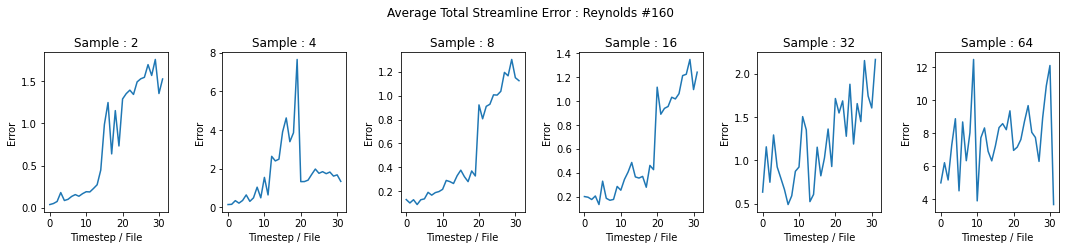

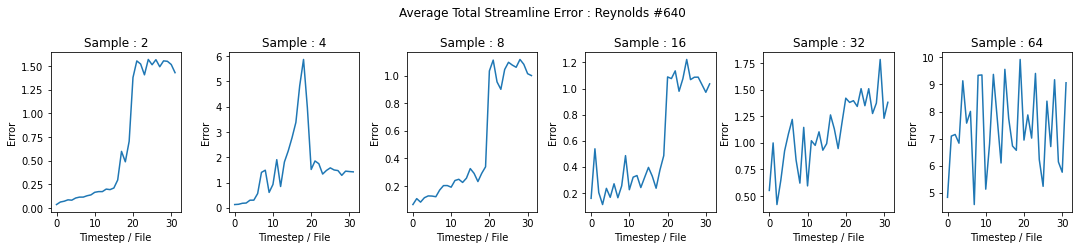

In [17]:
downsamples = 6
tot_errors160 = plot_file_errors(total_errors160, downsamples, 160)
tot_errors640 = plot_file_errors(total_errors640, downsamples, 640)

In [18]:
def plot_avg_tot_errors(ave_file_errs_samp160, ave_file_errs_samp640, downsample_size):
    sampled_errors160 = []
    sampled_errors640 = []
    for ave_file_errs160, ave_file_errs640 in zip(ave_file_errs_samp160, ave_file_errs_samp640):
        sampled_errors160.append(np.average(ave_file_errs160))
        sampled_errors640.append(np.average(ave_file_errs640))
        
    x = []
    for i in range(downsample_size):
        x.append(2**(i+1))
    fig, axs = plt.subplots(1,2, figsize=(15, 3.5))
    
    fig.suptitle(f'Streamline Error')
    axs[0].set_title(f'Reynolds : 160')
    axs[1].set_title(f'Reynolds : 640')
    axs[0].set(xlabel='Downsample Size', ylabel='Error')
    axs[1].set(xlabel='Downsample Size', ylabel='Error')
    axs[0].plot(x, sampled_errors160)
    axs[1].plot(x, sampled_errors640)           
    fig.tight_layout()
    plt.show()

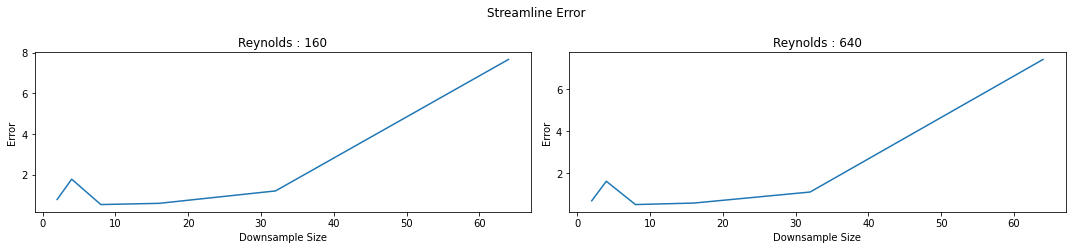

In [19]:
plot_avg_tot_errors(tot_errors160, tot_errors640, 6)